# WildlifeReID-10k analysis

This notebook analyzes the WildlifeReID-10k dataset. First load the necessary packages. 

In [1]:
import sys
sys.path.insert(0, '..')

import os
import numpy as np
import pandas as pd
from wildlife_datasets import datasets, splits
from utils import license_conversion, getFolderSize, rename_index, load_clusters

We specify the roots, load the dataset and features and verify whether the orderings of the dataset and the features correspond to each other.

In [2]:
root = '/data/wildlife_datasets/data/WildlifeReID10k'
root_images = os.path.join(root, 'images')
save_clusters_prefix = 'clusters/cluster'
d = datasets.WildlifeReID10k(root)
df = d.df
df['date'] = pd.to_datetime(df['date'])
if not np.array_equal(df.index, range(len(df))):
    raise Exception('Index must be 0..n')
features_names = np.load('features/features_dino_names.npy', allow_pickle=True)
if not np.array_equal(df['path'], features_names):
    raise Exception('Features were computed for different indices')

We show a summary of each species based on both the number of images and individuals.

In [3]:
summary_species = {}
for name, df_red in df.groupby('species'):
    summary_species[name] = {
        'images': len(df_red),
        'individuals': df_red['identity'].nunique(),
    }
summary_species = pd.DataFrame(summary_species).T
summary_species.loc['TOTAL'] = summary_species.sum()
with open('summary_species.txt', 'w') as text_file:
    text_file.write(summary_species.to_latex())
summary_species

images  individuals
bird         35077           40
cat          13021          509
chimpanzee    6771           95
cow          20724          375
dog          10020         1584
doplhin       2657           82
fish          6672            6
giraffe       2032          329
hyena         3129          256
leopard       6806          430
nyala         1942          237
panda         6874           50
polar bear   13918           13
sea star      2187           95
sea turtle   21532         2703
seal          2080           57
shark         7693          543
tiger         5415          182
whale         8559          788
zebra        37153         1970
TOTAL       214262        10344

Similarly, we show a summary of each dataset. We also add under which licenses were the datasets published.

In [4]:
summary_datasets = {}
for name, df_red in df.groupby('dataset'):
    metadata = eval(f'datasets.{name}.metadata')
    if 'licenses' in metadata:
        license = metadata['licenses']
    else:
        license = 'Missing'    
    summary_datasets[name] = {
        'images': len(df_red),
        'individuals': df_red['identity'].nunique(),
        'size (GB)': np.round(getFolderSize(os.path.join(root_images, name)) / 1024**3, 2),
        'license': license_conversion[license],
    }

summary_datasets = pd.DataFrame(summary_datasets).T.sort_index(key=lambda x: x.str.lower())
summary_datasets.loc['TOTAL'] = summary_datasets.sum()
summary_datasets.loc['TOTAL', 'license'] = ''
for col in ['images', 'individuals']:
    summary_datasets[col] = summary_datasets[col].astype(int)
for col in ['size (GB)']:
    summary_datasets[col] = summary_datasets[col].astype(float)
with open('summary_datasets.txt', 'w') as text_file:
    text_file.write(rename_index(summary_datasets).to_latex(float_format="%.2f"))
summary_datasets

images  individuals  size (GB)              license
AAUZebraFish           6672            6       0.37            CC BY 4.0
AerialCattle2017       4700           23       0.03        NC-Government
ATRW                   5415          182       0.27      CC BY-NC-SA 4.0
BelugaID               8559          788       0.26  CDLA-Permissive-1.0
BirdIndividualID      52274           50       0.50                 None
CatIndividualImages   13021          509       9.01            CC BY 4.0
CowDataset             1485           13       1.66            CC BY 4.0
Cows2021               8670          179       0.11        NC-Government
CTai                   4662           71       0.33                Other
CZoo                   2109           24       0.24                Other
DogFaceNet             8363         1393       0.08                  MIT
FriesianCattle2015      193           25       0.03        NC-Government
FriesianCattle2017      940           89       0.18        NC-Government
Giraffes               1393          178       0.09                 None
GiraffeZebraID         6925         2056       1.03  CDLA-Permissive-1.0
HyenaID2022            3129          256       0.44  CDLA-Permissive-1.0
IPanda50               6874           50       0.35                 None
LeopardID2022          6806          430       0.85  CDLA-Permissive-1.0
MPDD                   1657          191       0.02            CC BY 4.0
NDD20                  2657           82       0.07      CC BY-NC-SA 4.0
NyalaData              1942          237       0.46                 None
OpenCows2020           4736           46       0.04        NC-Government
PolarBearVidID        13918           13       0.07            CC BY 4.0
SealID                 2080           57       0.26            CC BY 4.0
SeaStarReID2023        2187           95       1.66  CDLA-Permissive-1.0
SeaTurtleID2022        8729          438       0.13                Other
SMALST                12850           10       0.84                  MIT
StripeSpotter           820           45       0.02         CC BY-SA 3.0
WhaleSharkID           7693          543       1.57  CDLA-Permissive-1.0
ZindiTurtleRecall     12803         2265       2.09         CC BY-SA 4.0
TOTAL                214262        10344      23.06

## Analysis of the split

We load the training and testing set and compute the identities in both sets. 

In [5]:
idx_train = np.where(df['split'] == 'train')[0]
idx_test = np.where(df['split'] == 'test')[0]
identity_train = df.iloc[idx_train]['identity'].unique()
identity_test = df.iloc[idx_test]['identity'].unique()
identity_test_only = set(identity_test) - set(identity_train)
identities = df['identity'].unique()

A short analysis of the split shows that the training set contains 78.75% images. There are 11.22% (approximaly half of the testing set) images who depict new individuals (not in the training set). The images in the training set only (941) are individuals with only one image.

In [6]:
splits.analyze_split(df, idx_train, idx_test)

Split: time-unaware open-set
Samples: train/test/unassigned/total = 168739/45523/0/214262
Classes: train/test/unassigned/total = 9437/9403/0/10344
Samples: train only/test only        = 941/24031
Classes: train only/test only/joint  = 941/907/8496

Fraction of train set     = 78.75%
Fraction of test set only = 11.22%


We now load the clusters based on which the split was created.

In [7]:
clusters_all = load_clusters(identities, save_clusters_prefix)

Performing a short analysis, we see that we found 11197 clusters with 29654 images and the majority of these clustered images is in the training set. The clustered images are 17.4% (29281/168739) of the training set. Without such clustering, some of these images would be in the testing set and there would be a significant leak between the training and testing sets.

In [8]:
n_clusters = 0
n_clustered_images = 0
n_clustered_images_train = 0
n_clustered_images_test = 0
n_clustered_images_test_only = 0
for identity in identities:
    if identity not in identity_test_only:
        for cluster in clusters_all[identity]:
            n_clusters += 1
            n_clustered_images += len(cluster)
            for i in cluster:
                if i in idx_train:
                    n_clustered_images_train += 1
                elif i in idx_test:
                    n_clustered_images_test += 1
print(f'There were {n_clusters} clusters with {n_clustered_images} images.')
print(f'Altogether {n_clustered_images_train} clustered images were in the training set.')
print(f'Altogether {n_clustered_images_test} clustered images were in the testing set.')

There were 11197 clusters with 29654 images.
Altogether 29281 clustered images were in the training set.
Altogether 373 clustered images were in the testing set.


Plotting clusters for each dataset shows that the clustered images are indeed very similar to each other.

/home/sadda/Projects/wildlife-datasets/baselines/../wildlife_datasets/datasets/datasets.py:305: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


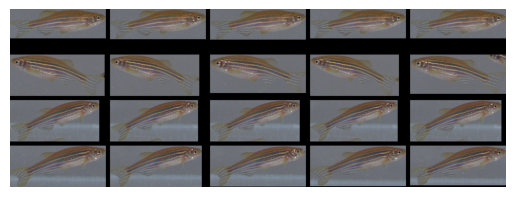

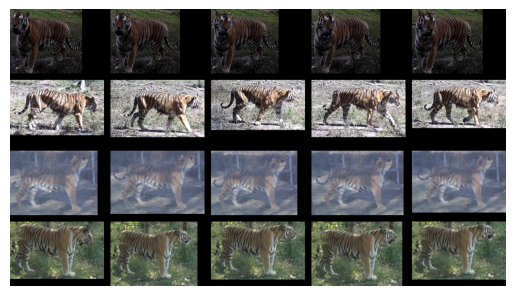

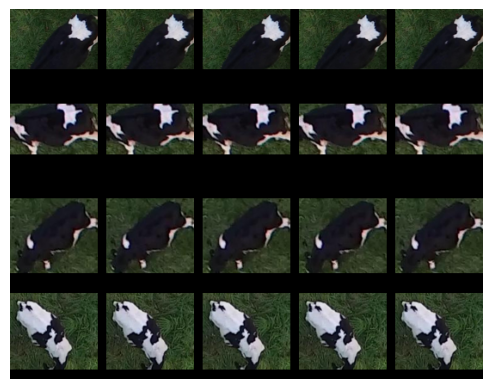

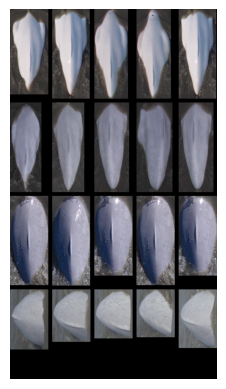

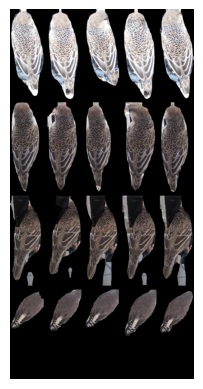

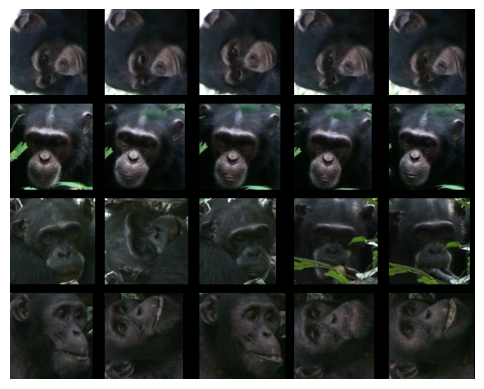

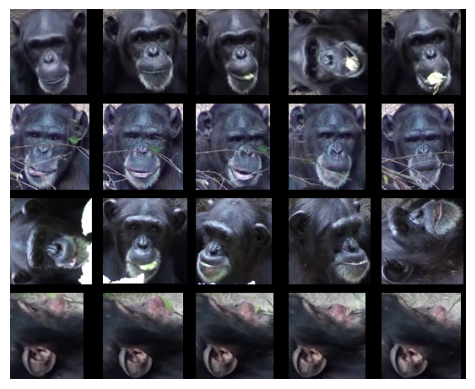

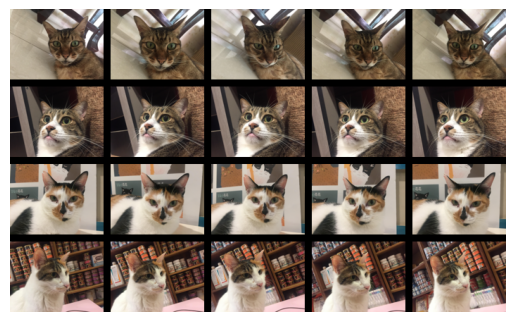

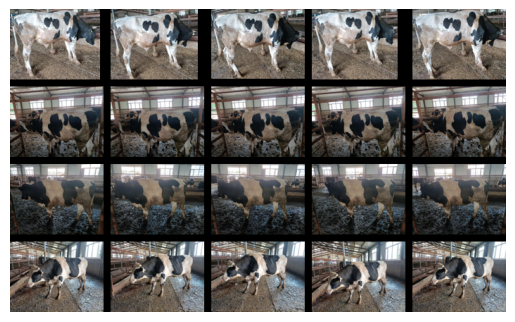

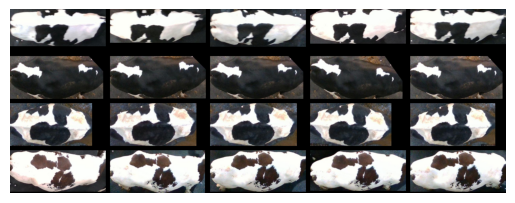

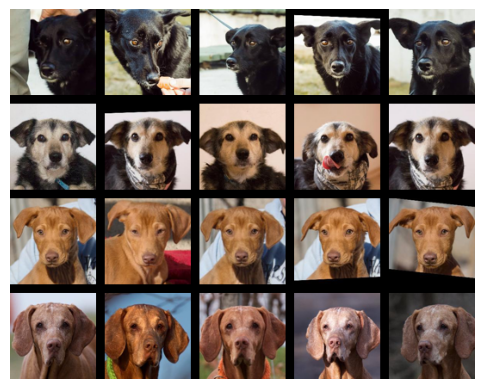

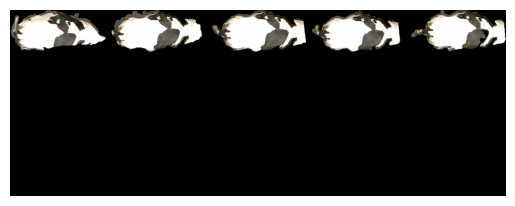

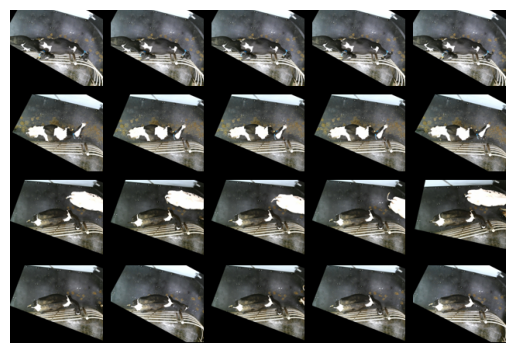

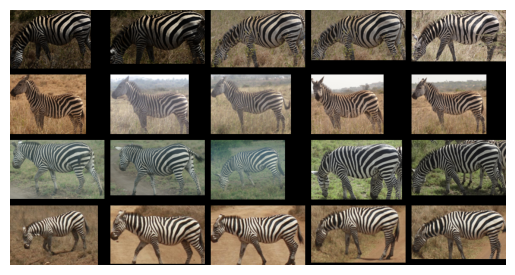

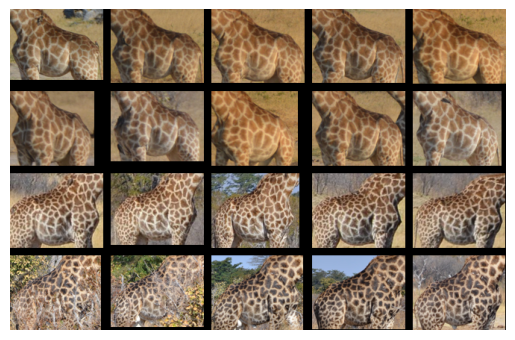

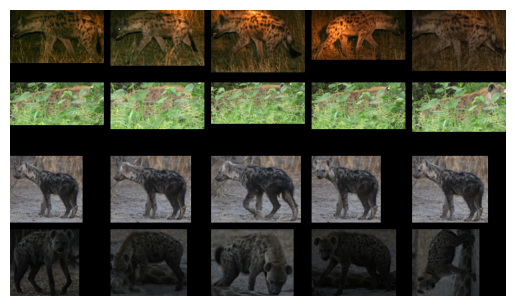

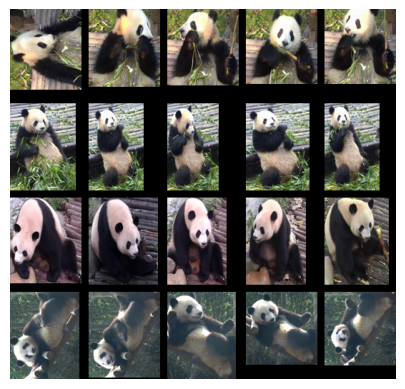

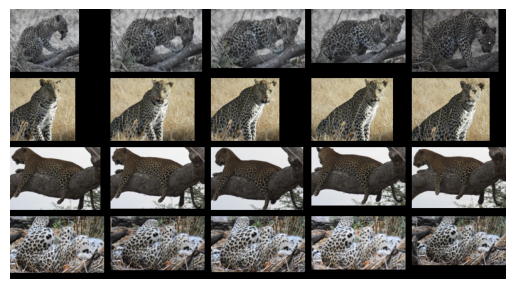

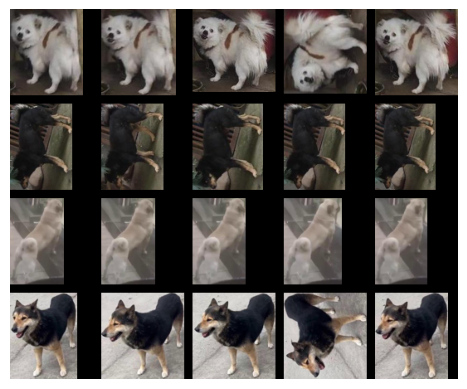

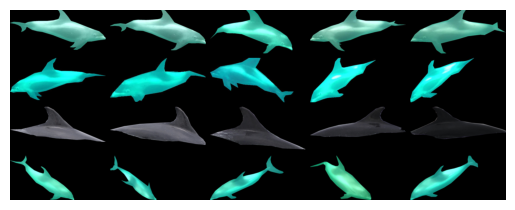

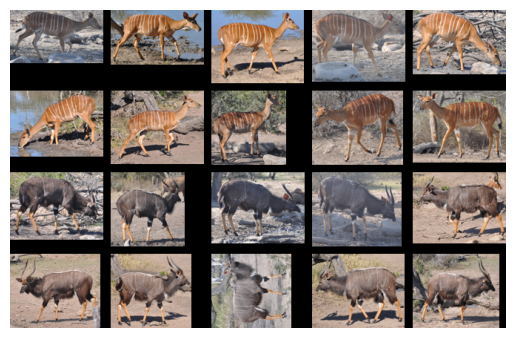

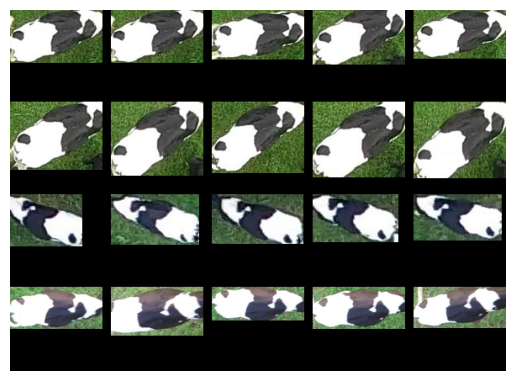

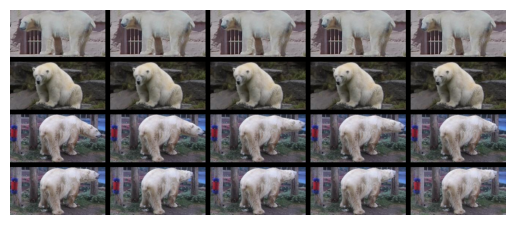

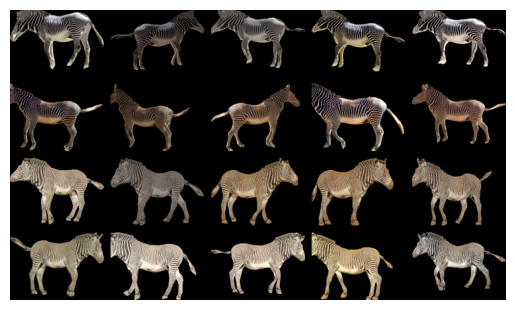

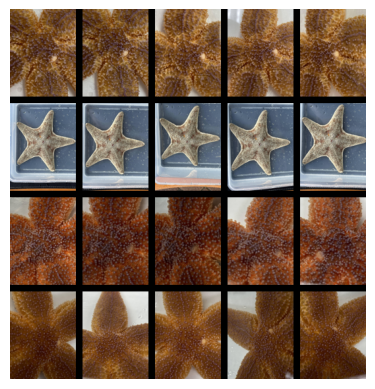

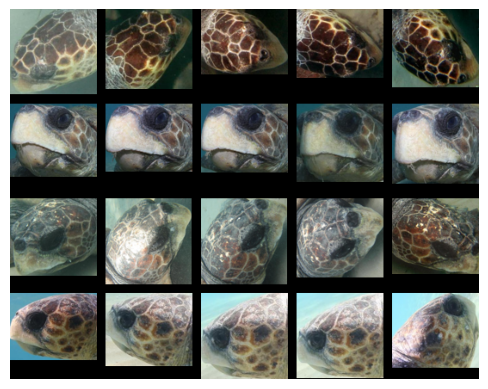

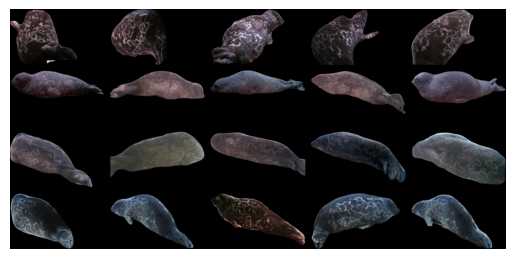

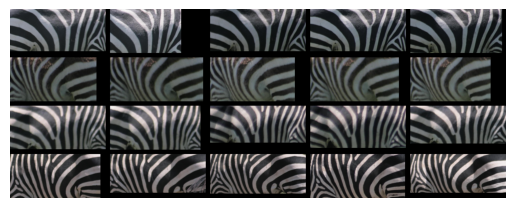

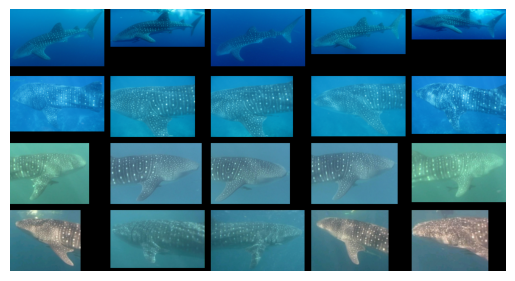

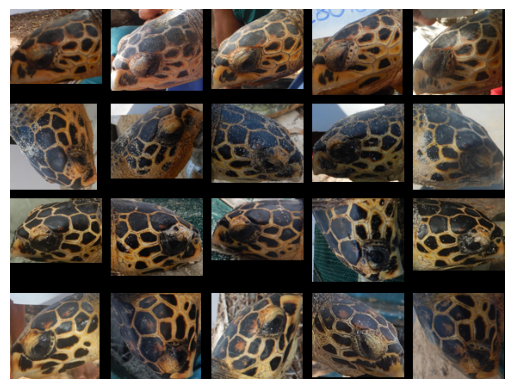

In [9]:
for _, df_dataset in df.groupby('dataset'):
    idx = []
    for identity in df_dataset['identity'].unique():
        for cluster in clusters_all[identity]:
            if len(cluster) == 5:
                idx += cluster
        if len(idx) >= 20:
            break
    if len(idx) > 0:
        d.plot_grid(idx=idx, n_rows=4, n_cols=5);